# TRANSIT FITTING with BATMAN!!!!
All credit goes to Laura Kreidberg for the development of BATMAN (cite: Kriedberg (2015), PASP) and the excellent documentation maintained here:  http://astro.uchicago.edu/~kreidberg/batman/index.html
All credit goes to Dan Foreman-Mackey and Contributors for the development of EMCEE (cite: Foreman-Mackey et al (2013), PASP) with documenation maintained here:  http://dan.iel.fm/emcee/current/

In [52]:
#Import required libraries
import sys
sys.path.append('/usr/lib64/python2.6/site-packages/')
sys.path.append('/usr/lib/python2.6/site-packages/')
sys.path.append('/ssw/apps/anaconda2/envs/astroconda/lib/python2.7/site-packages/')
import numpy as np
import batman #package by Laura Kreidberg:  http://astro.uchicago.edu/~kreidberg/batman/
import emcee  #package by Dan Foreman-Mackey:  http://dan.iel.fm/emcee/current/
import corner #package by Dan Foreman-Mackey:  http://corner.readthedocs.io/en/latest/
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
#Initialize Parameters 
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 1.                      #orbital period
params.rp = 0.1                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
#params.limb_dark = "nonlinear"        #limb darkening model ->"uniform", "linear", "quadratic", "nonlinear", etc.
#params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients
params.limb_dark = "linear"        #limb darkening model ->"uniform", "linear", "quadratic", "nonlinear", etc.
params.u = [0.2]      #limb darkening coefficients

t = np.linspace(-0.025, 0.025, 1000)        #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model

In [54]:
#Now let's make a light curve
flux = m.light_curve(params)                    #calculates light curve

[-0.025000000000000001, 0.025000000000000001, 0.9901172201158962, 1.001]

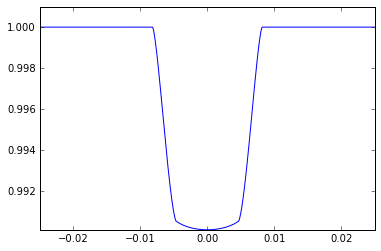

In [55]:
#Let's plot the light curve
plt.plot(t, flux)
plt.axis([t.min(), t.max(), flux.min(), 1.001])

Now take some time to adjust various parameters and see they affect the shape of the tranist light curve.  Pay particular attention to how your choices for limb darkening parameters and model affect the transit shape.

In [56]:
#We have saved light curves generated from the spectral extraction exercise.  Let's load that data.
import pickle
t, white_lc = pickle.load(open("GJ1214b_white.pickle","rb"))

#normalize white_lc
white_lc /= white_lc[0]

print t
print white_lc

[-0.03386452 -0.01689385 -0.01638631 -0.01604798 -0.01520229 -0.01351142
 -0.01182116 -0.01013143 -0.00844216 -0.00675327 -0.00506469 -0.00337633
 -0.00168813  0.          0.00168813  0.00337633  0.00506469  0.00675327
  0.00844216  0.01013143  0.01182116  0.01351142  0.01520229  0.01604798
  0.01638631  0.01689385  0.03386452]
[ 1.          0.9936239   0.99141041  0.98994105  0.98665352  0.98476993
  0.98419068  0.98382891  0.98357929  0.98340091  0.98327317  0.9831908
  0.98314471  0.9831296   0.98314471  0.9831908   0.98327317  0.98340091
  0.98357929  0.98382891  0.98419068  0.98476993  0.98665352  0.98994105
  0.99141041  0.9936239   1.        ]


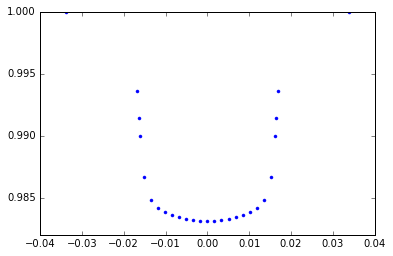

In [57]:
#Let's plot the 'white-light' light curve
plt.plot( t, white_lc, 'b.' )
#plt.axis([-0.04, 0.04, 0.984, 1.001])
#plt.plot(jdtot, white_lc)

In [58]:
#Above should be a nice clean noise-free light curve.  This is not realstic.
#Let's create some noised up more realistic data and do some MCMC fitting
n = t.size
flux = white_lc
err = 500.e-6  #100 ppm noise 
flux = flux + np.random.normal(0, err, n)

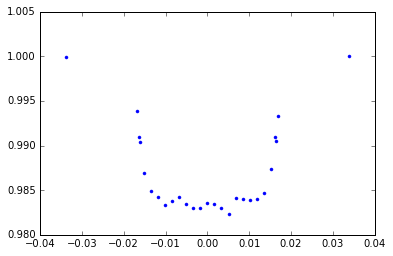

In [59]:
#Let's take a look at our noisy creation
plt.plot(t, flux, 'b.')

In the next few cells we're going to define some functions to assist with our fitting and allow us to interface the EMCEE and BATMAN.  

In [60]:
#intialize a transit model
def initialize_model(t, t0, per, rp, a, inc, ecc, w, u, limb_dark):
	params = batman.TransitParams()
	params.t0 = t0 
	params.per = per
	params.rp = rp
	params.a = a
	params.inc = inc
	params.ecc = ecc
	params.w = w
	params.u = u
	params.limb_dark = limb_dark      

	model = batman.TransitModel(params, t)

	return params, batman.TransitModel(params, t)    #return parameters and model objects 

In [61]:
#prior
def lnprior(theta):
	return 0.  #assumes all priors have uniform probability

In [62]:
#likelihood function 
def lnlike(theta, params, model, t, flux, err):
    params.rp, params.u = theta[0], [theta[1]]  #update parameters
    params.t0 = theta[2]
#    params.a, params.inc = theta[3], theta[4]
    lc = model.light_curve(params)
    residuals = flux - lc
    ln_likelihood = -0.5*(np.sum((residuals/err)**2 + np.log(2.0*np.pi*(err)**2)))

    return ln_likelihood

In [63]:
#posterior probability
def lnprob(theta, params, model, t, flux, err):
	lp = lnprior(theta)
	if not np.isfinite(lp):
		return -np.inf
	return lp + lnlike(theta, params, model, t, flux, err)

In [64]:
#Now for some initial parameter guesses
t0 = 0.  #time of inferior conjunction 
per = 1.58040456 #Period of GJ 1214 b  #orbital period -> contrained from other observations
rp = 0.125  #planet radius (in units of stellar radii)
a = 14.9   #semi-major axis (in units of stellar radii)
inc = 90. #orbital inclination (in degrees)
ecc = 0.  #eccentricity  -> Let's assume for now that the planet is not on an eccentric orbit
w = 90.   #longitude of periastron (in degrees) 
u = [0.3] #limb darkening coefficients
limb_dark = "linear" #limb darkening model -> Simple limb darkening model, need to consider other models

In [65]:
#initialize model and parameters
#fine grid for plot
t_fine = np.linspace(t[0],t[-1],100)
params_fine, m_fine = initialize_model(t_fine, t0, per, rp, a, inc, ecc, w, u, limb_dark)
#experimental grid for fit
params, m = initialize_model(t, t0, per, rp, a, inc, ecc, w, u, limb_dark)

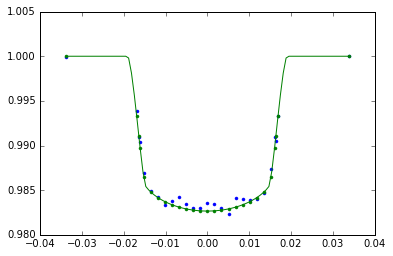

In [66]:
#compare your initial guess with the data and make adjustments
plt.plot(t, flux, '.') #blue
plt.plot(t_fine, m_fine.light_curve(params)) #green
plt.plot(t, m.light_curve(params), 'g.') #green

In [67]:
#now let's get the MCMC initialized
#initial guesses for MCMC fit parameters from your by eye fits
#for simplicity we will only fit for Rp/R*, limb darkening coefficient, and center of transit time
guess_rp, guess_u, guess_t0 = 0.125, 0.3, 0.
theta = [guess_rp, guess_u, guess_t0]

In [68]:
#initialize sampler
ndim, nwalkers = len(theta), 50
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (params, m, t, flux, err))
pos = [theta + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]

In [69]:
#run mcmc
sampler.run_mcmc(pos,1500);

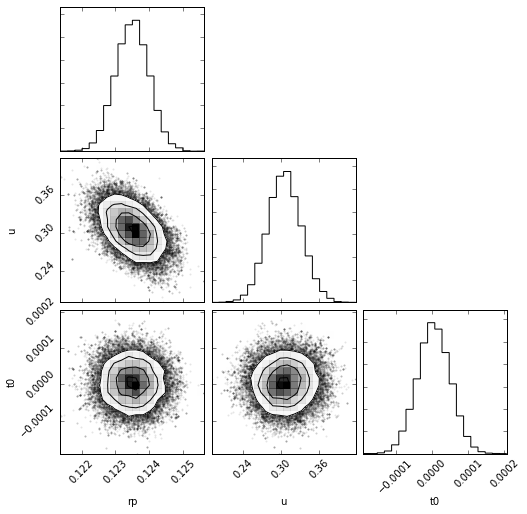

In [70]:
#make a pairs plot from MCMC output
import corner
samples = sampler.chain[:, 150:, :].reshape((-1, ndim)) #discard first 50 samples as burn-in
fig = corner.corner(samples, labels = ["rp", "u", "t0"])
plt.show()

Above you will see what is referred to as a 'corner plot', which gives you the posterior probability distributions for your transit parameters and shows the covariances between the parameters.  Take a moment to inspect the corner plot and note any strong covariances between parameters.  Think about what the histograms are telling you about the 'best-fit' value for each parameter. Go back and increase/decrease the value of the 'err' on your data and see how that affects the parameter distributions.

In [71]:
#Now we need to derive the best-fit planet parameters and their 1-sigma error bars
rp_mcmc, u_mcmc, t0_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print rp_mcmc
print u_mcmc
print t0_mcmc

(0.12349713953890461, 0.0004843641808437299, 0.00049919299793395322)
(0.30548695664964465, 0.026647661211285478, 0.025820706325246356)
(5.0920219386029717e-06, 4.5615637598437721e-05, 4.4437499700443975e-05)


Now that you've seen how it's done for the 'white-light' light curve, it's time to find out what kind of planet is in your data.  To produce a planetary transit spectrum, the fitting must be done as a function of wavelength.  The results from the 'white-light' light curve provide an important initial constraints.  Remember that as a function of wavelength only R$_p$/R$_{\star}$ and the limb darkening should change, the planetary orbital parameters are not wavelength dependent. The choice of limb darkening model and whether to fix or fit for the limb darkening parameters is widely discussed in the literature.  Your choices for limb darkening should be well justified from both a theoretical and statistical perspective.  Now, FIND YOUR PLANETARY SPECTRUM!!!

In [72]:
### MY STUFF ###

In [95]:
data = pickle.load( open('GJ1214b_16bands.pickle') ) #first column is times, second column is fluxes
bin16_lcs = data[1] 
N_bands = bin16_lcs.shape[1]
#!!! Note counts in here are not normalized yet !!!

[array([-0.03386452, -0.01689385, -0.01638631, -0.01604798, -0.01520229,
       -0.01351142, -0.01182116, -0.01013143, -0.00844216, -0.00675327,
       -0.00506469, -0.00337633, -0.00168813,  0.        ,  0.00168813,
        0.00337633,  0.00506469,  0.00675327,  0.00844216,  0.01013143,
        0.01182116,  0.01351142,  0.01520229,  0.01604798,  0.01638631,
        0.01689385,  0.03386452]), array([[ 247571.83653013,  284059.8428891 ,  396558.92120057,
         496363.93292103,  524941.0808822 ,  468585.26834664,
         603494.22208283,  782679.16809629,  890404.10483705,
         855491.39880914,  845063.4065661 ,  871150.50794099,
         751922.22414336,  488120.54596832,  174670.37553656,
          40669.39625425],
       [ 245998.37784227,  282235.06189932,  394001.90441819,
         493091.44434458,  521635.02133843,  465657.95722799,
         599803.97096818,  777625.76501344,  884737.48677834,
         850122.73201728,  839695.47526594,  865472.47925719,
         747069.762

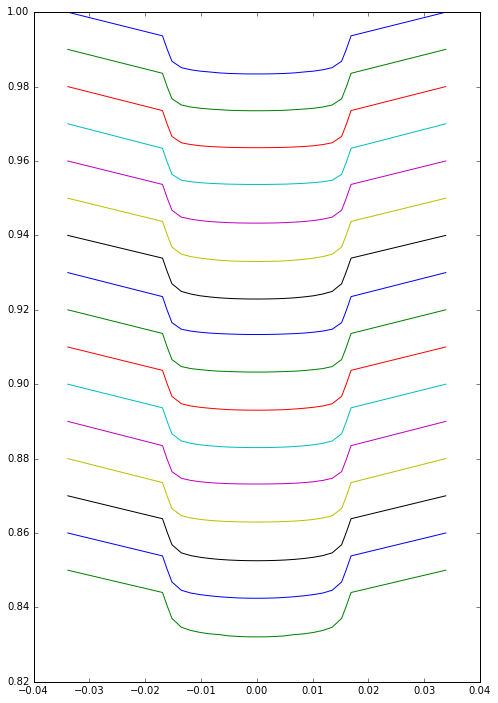

In [98]:
#plot all the different bands
plt.figure(figsize=(8,12))
for i_band in range(N_bands):
    plt.plot(t, bin16_lcs[:,i_band]/bin16_lcs[:,i_band][0] - i_band*0.01)

In [99]:
#Now for some initial parameter guesses
t0 = t0_mcmc[0]  #time of inferior conjunction 
per = 1.58040456 #Period of GJ 1214 b  #orbital period -> contrained from other observations
rp = 0.125  #planet radius (in units of stellar radii)
rp = rp_mcmc[0]  #planet radius (in units of stellar radii)
a = 14.9   #semi-major axis (in units of stellar radii)
inc = 90. #orbital inclination (in degrees)
ecc = 0.  #eccentricity  -> Let's assume for now that the planet is not on an eccentric orbit
w = 90.   #longitude of periastron (in degrees) 
u = [u_mcmc[0]] #limb darkening coefficients
limb_dark = "linear" #limb darkening model -> Simple limb darkening model, need to consider other models

In [100]:
#initialize model and parameters
params, model = initialize_model(t, t0, per, rp, a, inc, ecc, w, u, limb_dark)

In [101]:
#now let's get the MCMC initialized
#initial guesses for MCMC fit parameters from the white lightcurve
#only fit for Rp/R* and limb darkening coefficient
guess_rp, guess_u = 0.12, 0.3
theta = [guess_rp, guess_u]

In [102]:
#define NEW likelihood function 
def lnlike(theta, params, model, t, flux, err):
    params.rp, params.u = theta[0], [theta[1]]  #update parameters
    lc = model.light_curve(params)
    residuals = flux - lc
    ln_likelihood = -0.5*(np.sum((residuals/err)**2 + np.log(2.0*np.pi*(err)**2)))

    return ln_likelihood

In [103]:
def mcmc(dic, i_band, theta, params, model, t, flux, err):
    #initialize sampler
    ndim, nwalkers = len(theta), 50
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (params, model, t, flux, err))
    pos = [theta + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]

    #run mcmc
    sampler.run_mcmc(pos,1500);
    
    #make a pairs plot from MCMC output
    import corner
    samples = sampler.chain[:, 150:, :].reshape((-1, ndim)) #discard first 50 samples as burn-in
    fig = corner.corner(samples, labels = ["rp", "u"])
    plt.savefig('corner_'+str(err)+'_band_'+str(i_band)+'.pdf')

    #Now we need to derive the best-fit planet parameters and their 1-sigma error bars
    rp_mcmc, u_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    np.savetxt('results_'+str(err)+'_band_'+str(i_band)+'.txt', np.hstack((rp_mcmc, u_mcmc)) ) 
    print np.hstack((rp_mcmc, u_mcmc))
    
    dic['rp_mean'][i_band] = rp_mcmc[0]
    dic['rp_ll'][i_band] = rp_mcmc[1]
    dic['rp_ul'][i_band] = rp_mcmc[2]
    dic['u_mean'][i_band] = u_mcmc[0]
    dic['u_ll'][i_band] = u_mcmc[1]
    dic['u_ul'][i_band] = u_mcmc[2]
    
    return dic

In [104]:
err = 500.e-6  #100 ppm noise 

0
[ 0.1233271   0.00048448  0.00048616  0.30945742  0.02596848  0.0266791 ]
1
[ 0.12296555  0.00049544  0.00048593  0.29978809  0.02661044  0.026455  ]
2
[ 0.12313308  0.00048851  0.00050889  0.23531327  0.02859605  0.02835333]
3
[ 0.12306158  0.00049613  0.00048765  0.22243187  0.02709891  0.0282142 ]
4
[ 0.12317625  0.00048921  0.00048764  0.27173361  0.02640976  0.02750049]
5
[ 0.12372107  0.00048492  0.00049382  0.32991224  0.02615186  0.02571743]
6
[ 0.12380565  0.00048297  0.00048659  0.3517679   0.02506238  0.02625785]
7
[ 0.12379859  0.00048587  0.00048792  0.24440552  0.02792166  0.02704809]
8
[ 0.12386396  0.00048836  0.00048449  0.23457323  0.02720599  0.02754589]
9
[ 0.12415907  0.00048936  0.00048627  0.33867545  0.0254862   0.02646371]
10
[ 0.12409606  0.00048579  0.0004945   0.34772776  0.02578552  0.02596795]
11
[ 0.12440924  0.000494    0.00049632  0.26070311  0.02817532  0.02780528]
12
[ 0.12499853  0.00050074  0.00050868  0.31367226  0.0256043   0.02585663]
13
[ 0.12

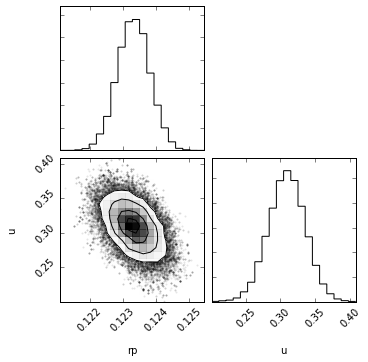

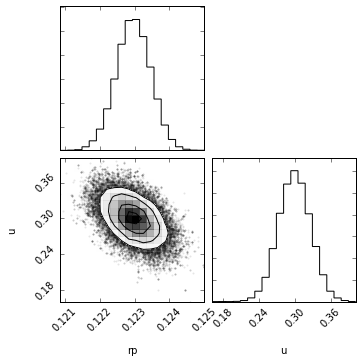

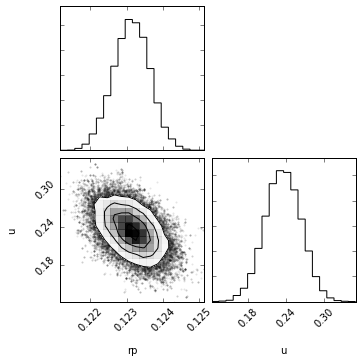

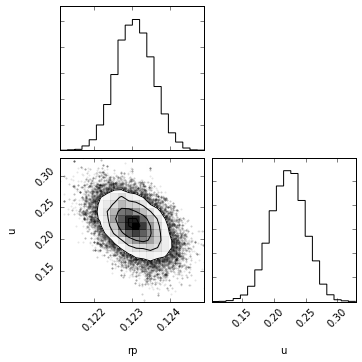

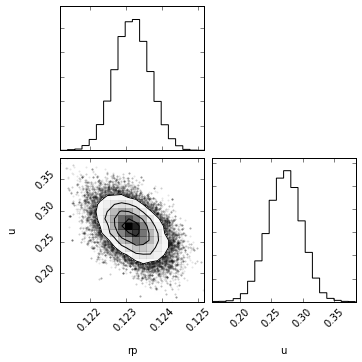

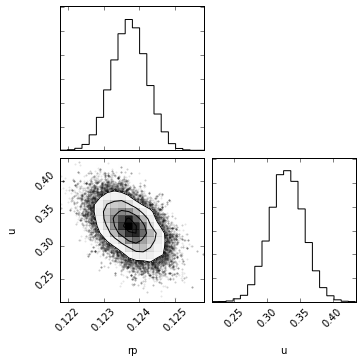

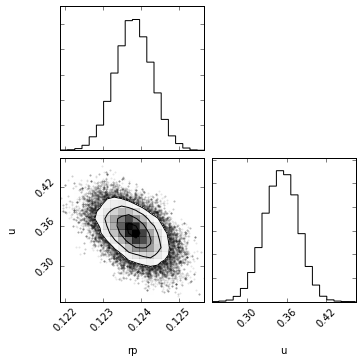

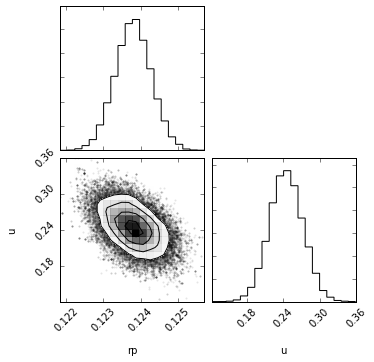

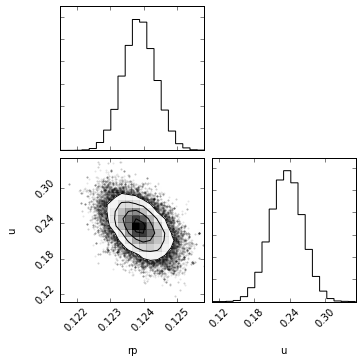

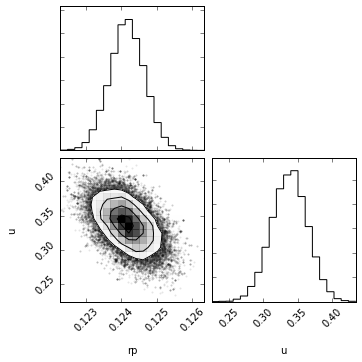

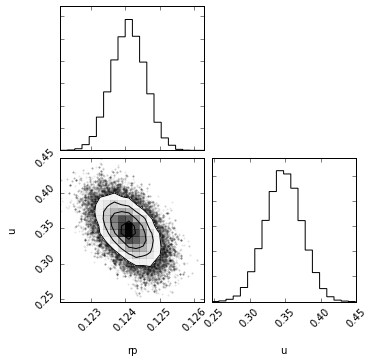

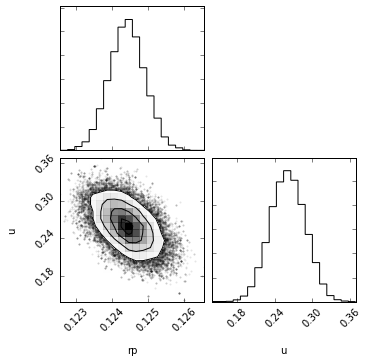

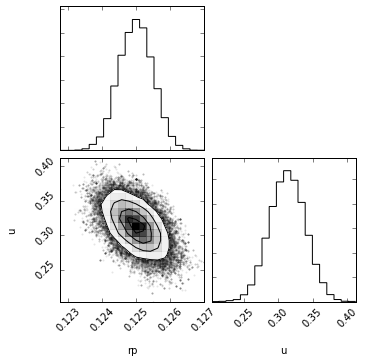

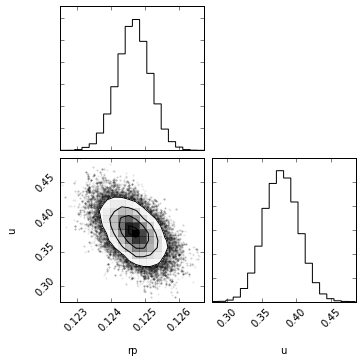

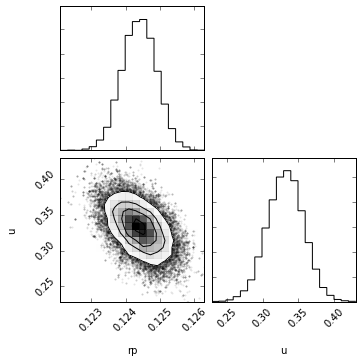

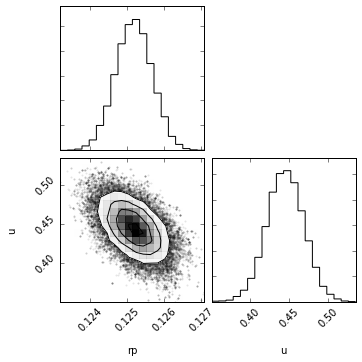

In [106]:
dic = {}
dic['rp_mean'], dic['rp_ll'], dic['rp_ul'], dic['u_mean'], dic['u_ll'], dic['u_ul'] = np.zeros((6,N_bands))
for i_band in range(N_bands):
    print i_band
    #load flux
    flux = bin16_lcs[:,i_band] / bin16_lcs[:,i_band][0]
    #put error on flux
    flux = flux + np.random.normal(0, err, n)
    #run mcmc
    dic = mcmc(dic, i_band, theta, params, model, t, flux, err)

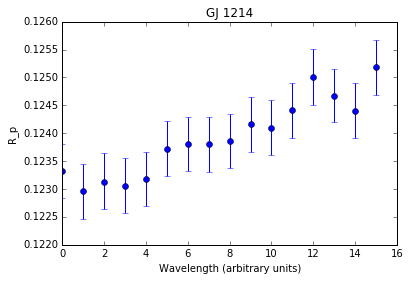

In [109]:
plt.figure()
asymmetric_error = [ dic['rp_ll'], dic['rp_ul'] ]
plt.errorbar( range(N_bands), dic['rp_mean'], yerr=asymmetric_error, fmt='o' )
plt.savefig('spectrums_'+str(err)+'.pdf')
plt.ylabel('R_p')
plt.xlabel('Wavelength (arbitrary units)')
plt.title('GJ 1214')